# Train MPOX detection models

Based on the paper *"Deep learning based detection of monkeypox virus using skin lesion images"* by T. Nayak et al., 2023. but using another public image dataset.

Will fine tune a CNN model:
- Dataset: MSLID Binary version (moved non MPOX images into class 'Other')
- Architecture: resnet 18

## Imports and Setup

In [1]:
from eccore.ipython import nb_setup
nb_setup()

import matplotlib.pyplot as plt
import re
import torch
import umap

from pprint import pprint
from uuid import uuid4
from IPython.display import Markdown, display


from fastai import __version__ as fastai_version
from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback
from pathlib import Path
from utils import run_experiment, create_image_features, plot_features, parse_saved_fnames, ROOT, DATASETS
from utils import validate_models, plot_training_and_validation_metrics, model_weight_files

print(f"Using fastai version {fastai_version}")
saved = ROOT / "saved"
data = ROOT / "data"

train_ds = "msid-binary"
p2train_ds = DATASETS[train_ds]['path']
assert p2train_ds.is_dir(), f"Training dataset path {p2train_ds} is not a directory."
print(f"This notebook will use {train_ds} training dataset ({p2train_ds})")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# styles = plt.style.available
plt.style.use('default')

Added path: /home/vtec/projects/bio/mpox-prestudy/src
Set autoreload mode
Using fastai version 2.8.3
This notebook will use msid-binary training dataset (/home/vtec/projects/bio/mpox-prestudy/data/MSID-binary)
Using device: cuda


In [2]:
imgs_train_ds = get_image_files(p2train_ds)
imgs_mpox = get_image_files(p2train_ds / "Monkeypox")
imgs_others = get_image_files(p2train_ds / "Others")
print(f"Training dataset ({train_ds}): {len(imgs_train_ds):,} images found in {p2train_ds}")
print(f" - Monkeypox: {len(imgs_mpox):,} images")
print(f" - Others:    {len(imgs_others):,} images")

Training dataset (msid-binary): 770 images found in /home/vtec/projects/bio/mpox-prestudy/data/MSID-binary
 - Monkeypox: 279 images
 - Others:    491 images


Quick review of the training dataset

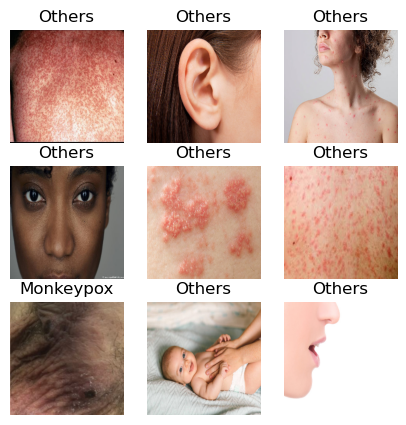

In [3]:
dls = ImageDataLoaders.from_folder(
    path=p2train_ds,
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
dls.show_batch(max_n=9, figsize=(5,5), show=True)

In [4]:
# run_experiment(resnet18, train_ds='msld-v1', freeze_epochs=1, n_epoch=4, lr=1e-3, bs=32, suggested_lr='minimum', save_records=False)

## Fine tune model (resnet18) with `msid-binary`

Running experiment 1/4: bs=32; lr=None
> Finding learning rate...


  lrs.minimum: 8.32e-03 
  lrs.steep  : 5.25e-03  
  lrs.valley : 8.32e-04


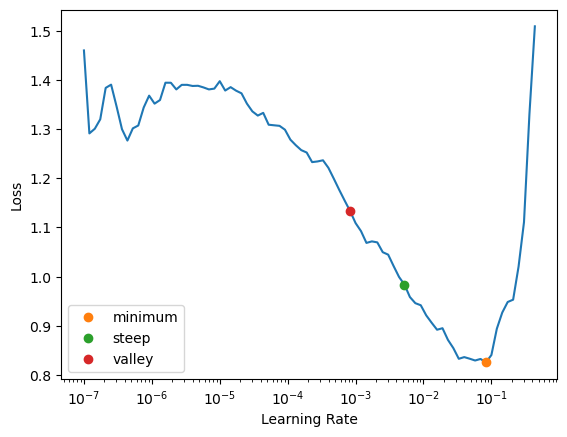

  Using valley learning rate: 8.32e-04

records will be saved as resnet18_200_32_8.3e-04_msid-binary_xxxx_7ae3d2bf-a42c-42d8-bf43-a68fd7967775.xxx
> Fine-tuning resnet18 on msid-binary for 200 epochs with batch size 32 ...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.965576,0.395153,0.833333,0.909091,0.844156,0.869565,00:01


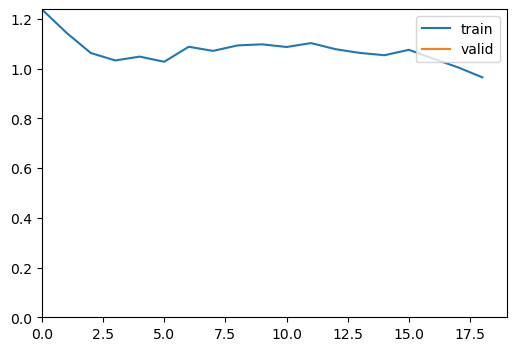

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.467968,0.423731,0.802083,0.927711,0.837662,0.860335,00:01
1,0.415853,0.423177,0.812500,0.917647,0.837662,0.861878,00:01
2,0.340093,0.403320,0.822917,0.897727,0.831169,0.858696,00:01
3,0.275806,0.411755,0.812500,0.866667,0.805195,0.838710,00:01
4,0.253578,0.403579,0.843750,0.900000,0.844156,0.870968,00:01
5,0.228110,0.408807,0.854167,0.901099,0.850649,0.877005,00:02
6,0.192739,0.405285,0.885417,0.876289,0.850649,0.880829,00:01
7,0.155994,0.408921,0.864583,0.892473,0.850649,0.878307,00:01
8,0.132171,0.423786,0.885417,0.894737,0.863636,0.890052,00:01
9,0.109111,0.421780,0.875000,0.903226,0.863636,0.888889,00:01


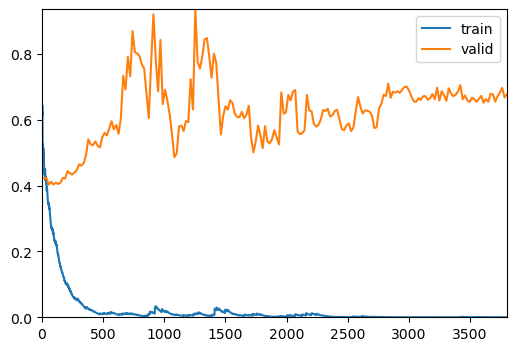

> Saving training records...
  Weights:  resnet18_200_32_8.3e-04_msid-binary_weights_7ae3d2bf-a42c-42d8-bf43-a68fd7967775.pth
  Metrics:  resnet18_200_32_8.3e-04_msid-binary_metrics_7ae3d2bf-a42c-42d8-bf43-a68fd7967775.csv
  Losses:   resnet18_200_32_8.3e-04_msid-binary_losses_7ae3d2bf-a42c-42d8-bf43-a68fd7967775.csv
  Metadata: resnet18_200_32_8.3e-04_msid-binary_metadata_7ae3d2bf-a42c-42d8-bf43-a68fd7967775.txt
  Curves:   resnet18_200_32_8.3e-04_msid-binary_curves_7ae3d2bf-a42c-42d8-bf43-a68fd7967775.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 200
Batch Size: 32
Learning Rate: 8.3e-04
Metrics:
	recall_score: 0.958333
	precision_score: 0.901961
	accuracy: 0.909091
	f1_score: 0.929293

UID: 7ae3d2bf-a42c-42d8-bf43-a68fd7967775
----------------------------------------

Running experiment 2/4: bs=16; lr=None
> Finding learning rate...


  lrs.minimum: 4.79e-03 
  lrs.steep  : 2.51e-05  
  lrs.valley : 1.00e-03


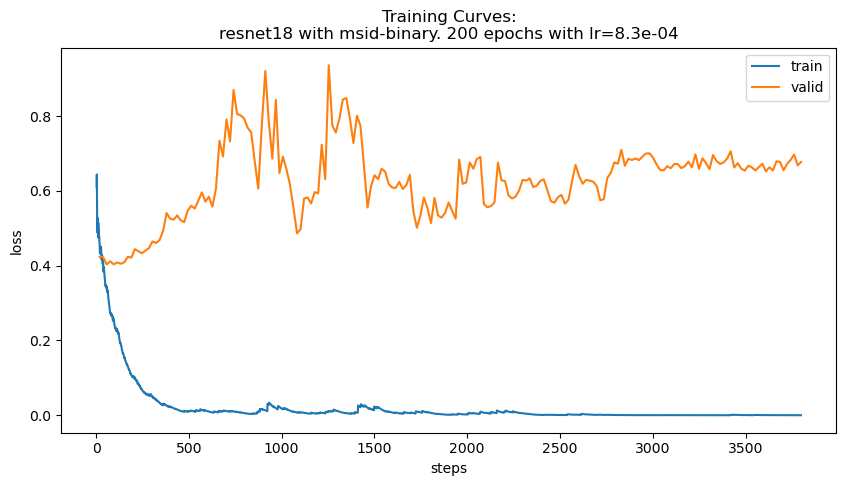

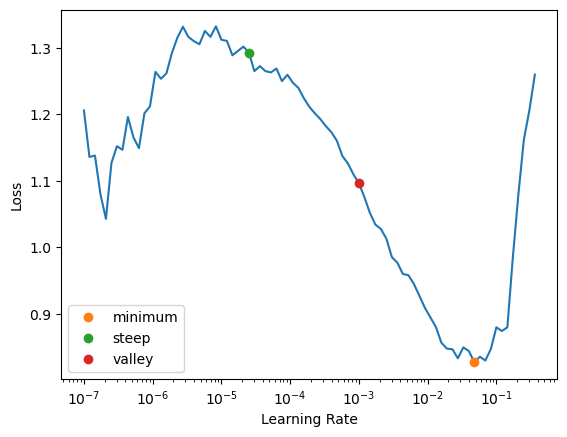

  Using valley learning rate: 1.00e-03

records will be saved as resnet18_200_16_1.0e-03_msid-binary_xxxx_b01772cd-86fd-4e68-949a-e4e5f16a3fdb.xxx
> Fine-tuning resnet18 on msid-binary for 200 epochs with batch size 16 ...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.909256,0.369573,0.916667,0.907216,0.889610,0.911917,00:01


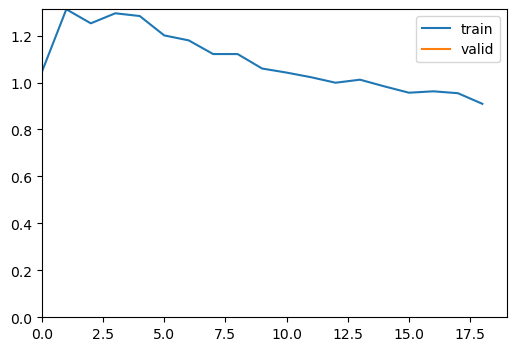

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.492314,0.366277,0.875000,0.913043,0.870130,0.893617,00:01
1,0.393994,0.343792,0.885417,0.913978,0.876623,0.899471,00:01
2,0.338702,0.320554,0.916667,0.907216,0.889610,0.911917,00:01
3,0.299746,0.293565,0.927083,0.908163,0.896104,0.917526,00:01
4,0.261036,0.292311,0.927083,0.908163,0.896104,0.917526,00:01
5,0.216175,0.281424,0.937500,0.909091,0.902597,0.923077,00:01
6,0.185296,0.284026,0.947917,0.910000,0.909091,0.928571,00:01
7,0.152884,0.302760,0.937500,0.900000,0.896104,0.918367,00:01
8,0.136419,0.292516,0.937500,0.900000,0.896104,0.918367,00:02
9,0.110241,0.281704,0.937500,0.900000,0.896104,0.918367,00:01


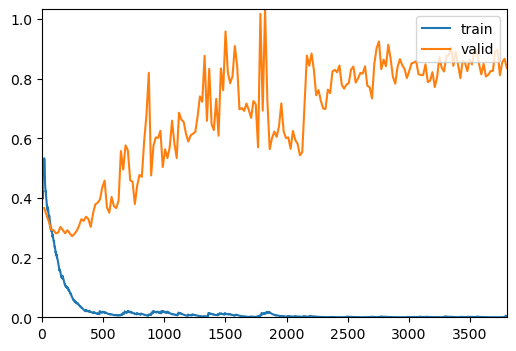

> Saving training records...
  Weights:  resnet18_200_16_1.0e-03_msid-binary_weights_b01772cd-86fd-4e68-949a-e4e5f16a3fdb.pth
  Metrics:  resnet18_200_16_1.0e-03_msid-binary_metrics_b01772cd-86fd-4e68-949a-e4e5f16a3fdb.csv
  Losses:   resnet18_200_16_1.0e-03_msid-binary_losses_b01772cd-86fd-4e68-949a-e4e5f16a3fdb.csv
  Metadata: resnet18_200_16_1.0e-03_msid-binary_metadata_b01772cd-86fd-4e68-949a-e4e5f16a3fdb.txt
  Curves:   resnet18_200_16_1.0e-03_msid-binary_curves_b01772cd-86fd-4e68-949a-e4e5f16a3fdb.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 200
Batch Size: 16
Learning Rate: 1.0e-03
Metrics:
	recall_score: 0.968750
	precision_score: 0.894231
	accuracy: 0.909091
	f1_score: 0.930000

UID: b01772cd-86fd-4e68-949a-e4e5f16a3fdb
----------------------------------------

Running experiment 3/4: bs=64; lr=None
> Finding learning rate...


  lrs.minimum: 5.75e-03 
  lrs.steep  : 1.58e-06  
  lrs.valley : 5.75e-04


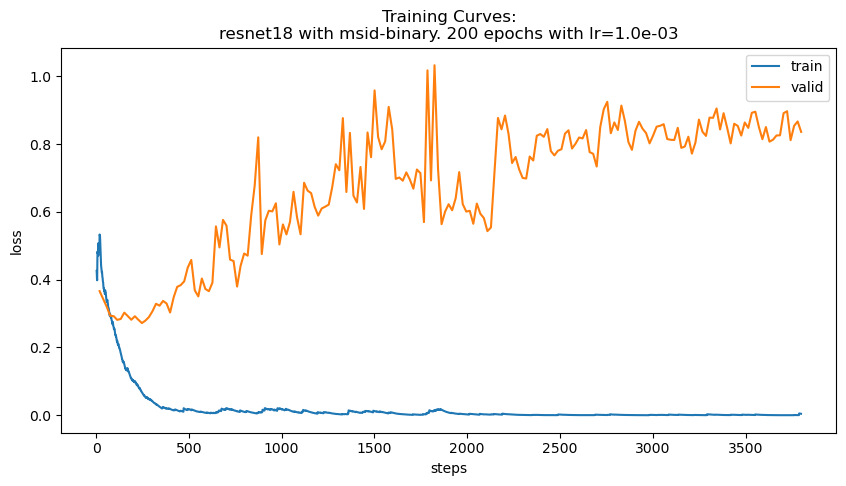

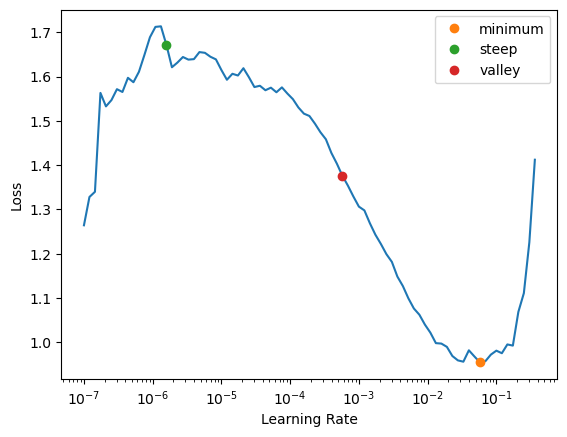

  Using valley learning rate: 5.75e-04

records will be saved as resnet18_200_64_5.8e-04_msid-binary_xxxx_cb224770-2f8c-439f-8fac-43ab3128c670.xxx
> Fine-tuning resnet18 on msid-binary for 200 epochs with batch size 64 ...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,1.140242,0.365563,0.930000,0.861111,0.857143,0.894231,00:01


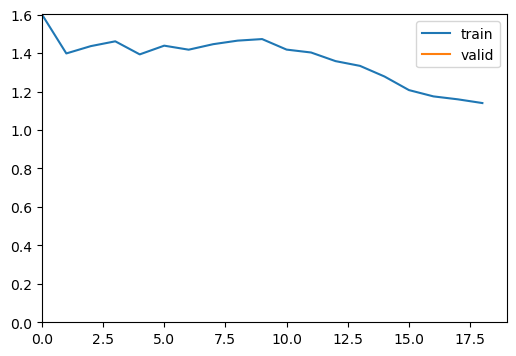

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.563011,0.408227,0.820000,0.921348,0.837662,0.867725,00:01
1,0.492540,0.394061,0.820000,0.931818,0.844156,0.872340,00:01
2,0.439184,0.382678,0.850000,0.934066,0.863636,0.890052,00:01
3,0.412943,0.350385,0.870000,0.925532,0.870130,0.896907,00:02
4,0.372763,0.366311,0.870000,0.925532,0.870130,0.896907,00:01
5,0.325350,0.344802,0.880000,0.936170,0.883117,0.907216,00:01
6,0.287062,0.346874,0.870000,0.935484,0.876623,0.901554,00:01
7,0.255964,0.319113,0.890000,0.927083,0.883117,0.908163,00:01
8,0.220716,0.332418,0.900000,0.937500,0.896104,0.918367,00:01
9,0.199189,0.344111,0.890000,0.936842,0.889610,0.912821,00:01


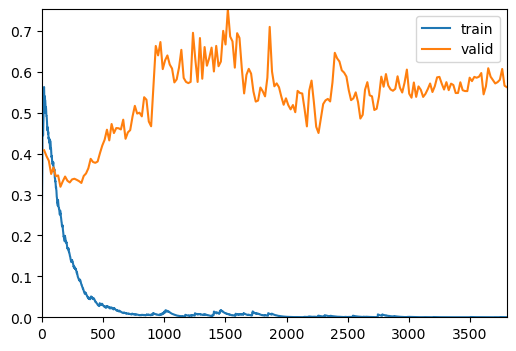

> Saving training records...
  Weights:  resnet18_200_64_5.8e-04_msid-binary_weights_cb224770-2f8c-439f-8fac-43ab3128c670.pth
  Metrics:  resnet18_200_64_5.8e-04_msid-binary_metrics_cb224770-2f8c-439f-8fac-43ab3128c670.csv
  Losses:   resnet18_200_64_5.8e-04_msid-binary_losses_cb224770-2f8c-439f-8fac-43ab3128c670.csv
  Metadata: resnet18_200_64_5.8e-04_msid-binary_metadata_cb224770-2f8c-439f-8fac-43ab3128c670.txt
  Curves:   resnet18_200_64_5.8e-04_msid-binary_curves_cb224770-2f8c-439f-8fac-43ab3128c670.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 200
Batch Size: 64
Learning Rate: 5.8e-04
Metrics:
	recall_score: 0.970000
	precision_score: 0.923810
	accuracy: 0.928571
	f1_score: 0.946341

UID: cb224770-2f8c-439f-8fac-43ab3128c670
----------------------------------------

Running experiment 4/4: bs=32; lr=None
> Finding learning rate...


  lrs.minimum: 2.75e-03 
  lrs.steep  : 3.31e-04  
  lrs.valley : 5.75e-04


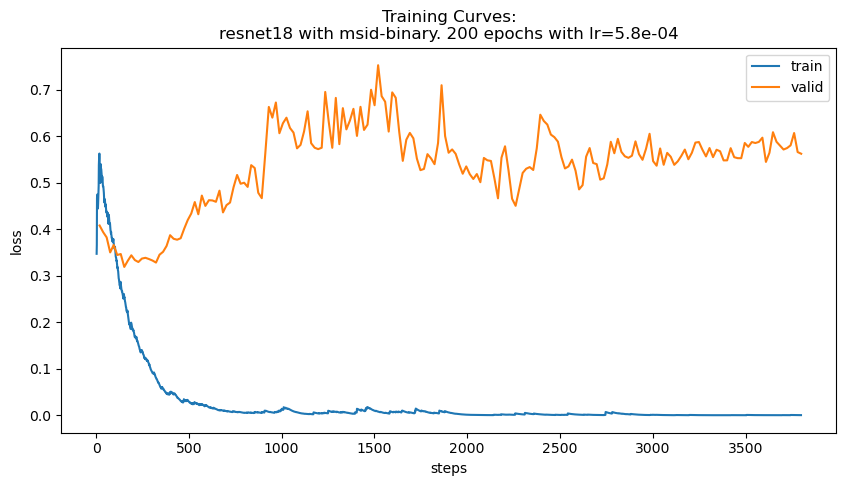

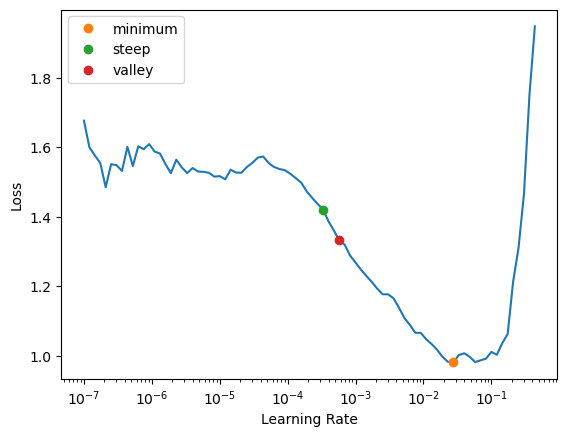

  Using valley learning rate: 5.75e-04

records will be saved as resnet18_200_32_5.8e-04_msid-binary_xxxx_d6094931-e123-4798-a1c8-d06365e92c26.xxx
> Fine-tuning resnet18 on msid-binary for 200 epochs with batch size 32 ...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,1.022841,0.332036,0.846939,0.932584,0.863636,0.887701,00:01


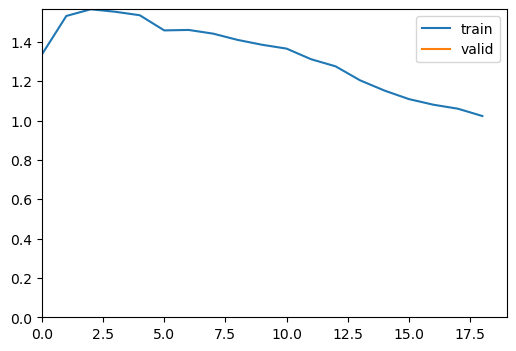

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.571897,0.330580,0.836735,0.953488,0.870130,0.891304,00:01
1,0.553428,0.298072,0.857143,0.954545,0.883117,0.903226,00:01
2,0.464345,0.286468,0.867347,0.965909,0.896104,0.913978,00:01
3,0.405171,0.254492,0.887755,0.966667,0.909091,0.925532,00:01
4,0.383077,0.237506,0.887755,0.966667,0.909091,0.925532,00:01
5,0.347523,0.268421,0.887755,0.977528,0.915584,0.930481,00:01
6,0.313231,0.258395,0.877551,0.977273,0.909091,0.924731,00:01
7,0.275162,0.230733,0.897959,0.977778,0.922078,0.936170,00:01
8,0.245798,0.242996,0.897959,0.967033,0.915584,0.931217,00:01
9,0.217916,0.236995,0.908163,0.967391,0.922078,0.936842,00:01


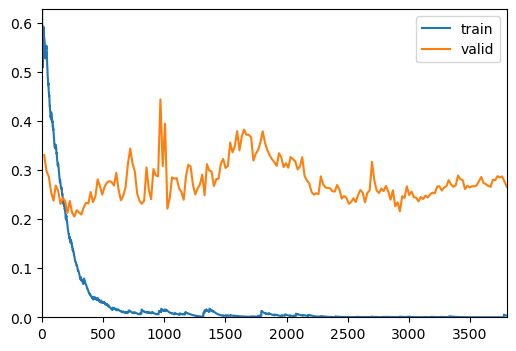

> Saving training records...
  Weights:  resnet18_200_32_5.8e-04_msid-binary_weights_d6094931-e123-4798-a1c8-d06365e92c26.pth
  Metrics:  resnet18_200_32_5.8e-04_msid-binary_metrics_d6094931-e123-4798-a1c8-d06365e92c26.csv
  Losses:   resnet18_200_32_5.8e-04_msid-binary_losses_d6094931-e123-4798-a1c8-d06365e92c26.csv
  Metadata: resnet18_200_32_5.8e-04_msid-binary_metadata_d6094931-e123-4798-a1c8-d06365e92c26.txt
  Curves:   resnet18_200_32_5.8e-04_msid-binary_curves_d6094931-e123-4798-a1c8-d06365e92c26.png


> Metadata:
Finetuning Run Info:

Model: resnet18
Freeze Epochs: 1
Epochs: 200
Batch Size: 32
Learning Rate: 5.8e-04
Metrics:
	recall_score: 0.979592
	precision_score: 0.950495
	accuracy: 0.954545
	f1_score: 0.964824

UID: d6094931-e123-4798-a1c8-d06365e92c26
----------------------------------------



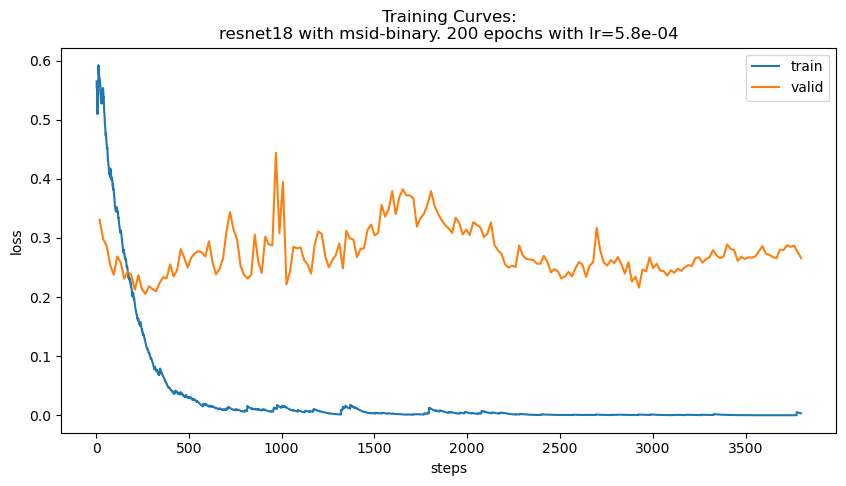

In [5]:
training_ds = 'msid-binary'

freeze_epochs = 1
n_epoch = 200
SAVE_RECORDS = True
# SAVE_RECORDS = False

hyperparams = (
    (None,32),
    (None,16),
    (None,64),
    (None,32)
)

for i, (lr, bs) in enumerate(hyperparams):
    print(f"Running experiment {i+1}/{len(hyperparams)}: bs={bs}; lr={lr}")
    learn = run_experiment(
        resnet18,
        train_ds=training_ds,
        freeze_epochs=freeze_epochs, 
        n_epoch=n_epoch, 
        lr=lr, 
        bs=bs,
        suggested_lr='valley',
        save_records=SAVE_RECORDS
    )
    print(f"{'-'*40}\n")

## Validate model

In [8]:
selected_arch = resnet18
training_ds = 'msid-binary'
validation_ds = 'msld-v1'

training_res_df, validation_res_df = validate_models(
    arch=selected_arch,
    training_ds=training_ds,
    validation_ds=validation_ds,
)

Found 770 images in training dataset MSID Binary.
Found 3,192 images in validation dataset MSLD-v1.
Found 9 model weight files
Validating model with weights from resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b


Validating model with weights from resnet18_200_16_1.0e-03_msid-binary_weights_b01772cd-86fd-4e68-949a-e4e5f16a3fdb


Validating model with weights from resnet18_200_32_8.3e-04_msid-binary_weights_7ae3d2bf-a42c-42d8-bf43-a68fd7967775


Validating model with weights from resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa


Validating model with weights from resnet18_200_32_5.8e-04_msid-binary_weights_d6094931-e123-4798-a1c8-d06365e92c26


Validating model with weights from resnet18_200_64_5.8e-04_msid-binary_weights_cb224770-2f8c-439f-8fac-43ab3128c670


Validating model with weights from resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503


Validating model with weights from resnet18_100_32_1.0e-03_msid-binary_weights_1611e192-a43e-4540-9e4e-63de0cc809f2


Validating model with weights from resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6


### Metrics while fine-tuning `resnet18` models:

Fine-tuned on 80% of `MSID Binary` image dataset and validated on 20%

,train_val_recall,train_val_precision,train_val_accuracy,train_val_f1
resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b,1.000000,0.944954,0.961039,0.971698
resnet18_200_16_1.0e-03_msid-binary_weights_b01772cd-86fd-4e68-949a-e4e5f16a3fdb,0.968750,0.894231,0.909091,0.930000
resnet18_200_32_8.3e-04_msid-binary_weights_7ae3d2bf-a42c-42d8-bf43-a68fd7967775,0.958333,0.901961,0.909091,0.929293
resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa,0.990291,0.918919,0.935065,0.953271
resnet18_200_32_5.8e-04_msid-binary_weights_d6094931-e123-4798-a1c8-d06365e92c26,0.979592,0.950495,0.954545,0.964824
resnet18_200_64_5.8e-04_msid-binary_weights_cb224770-2f8c-439f-8fac-43ab3128c670,0.970000,0.923810,0.928571,0.946341
resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503,1.000000,0.936364,0.954545,0.967136
resnet18_100_32_1.0e-03_msid-binary_weights_1611e192-a43e-4540-9e4e-63de0cc809f2,0.990196,0.918182,0.935065,0.952830
resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6,0.990291,0.935780,0.948052,0.962264


### Validation of fine-tuned `resnet18` models:

Validated on `MSLD-v1` image dataset

,recall,precision,accuracy,f1
resnet18_100_16_2.1e-03_msid-binary_weights_8c848f0d-1ca4-4503-9509-153c2308a88b,0.502538,0.874172,0.687326,0.638195
resnet18_200_16_1.0e-03_msid-binary_weights_b01772cd-86fd-4e68-949a-e4e5f16a3fdb,0.501904,0.875969,0.687674,0.638161
resnet18_200_32_8.3e-04_msid-binary_weights_7ae3d2bf-a42c-42d8-bf43-a68fd7967775,0.545051,0.869433,0.705432,0.670047
resnet18_100_64_2.1e-03_msid-binary_weights_3f569899-955b-4e4a-81cc-da8970237baa,0.545685,0.843137,0.694986,0.662558
resnet18_200_32_5.8e-04_msid-binary_weights_d6094931-e123-4798-a1c8-d06365e92c26,0.463198,0.854801,0.662256,0.600823
resnet18_200_64_5.8e-04_msid-binary_weights_cb224770-2f8c-439f-8fac-43ab3128c670,0.531726,0.889597,0.706825,0.665608
resnet18_100_32_1.4e-03_msid-binary_weights_e8d9ede8-c3be-4d50-8d98-8967df07e503,0.607234,0.817949,0.710306,0.697014
resnet18_100_32_1.0e-03_msid-binary_weights_1611e192-a43e-4540-9e4e-63de0cc809f2,0.565990,0.871945,0.716226,0.686418
resnet18_100_32_1.0e-03_msid-binary_weights_5e1525da-81f7-4a7a-bb8e-725a0cbe24c6,0.493020,0.886986,0.687326,0.633768


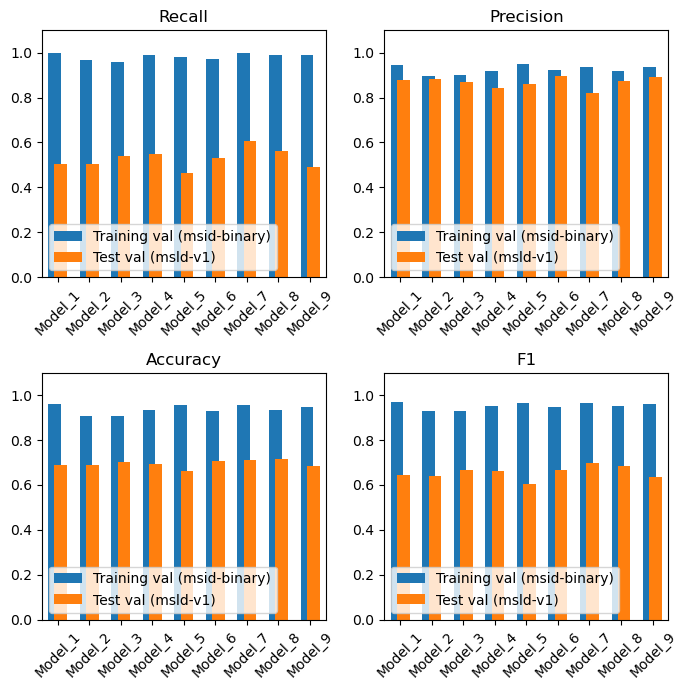

In [6]:
plot_training_and_validation_metrics(training_res_df, validation_res_df)

# Others